In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_path = "/kaggle/input/amazon-ml-dataset/student_resource/dataset/train.csv"
test_path = "/kaggle/input/amazon-ml-dataset/student_resource/dataset/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("✅ Train shape:", train.shape)
print("✅ Test shape:", test.shape)

train.head()

In [ ]:
# Check column types and null values
train.info()

print("\nMissing values per column:\n", train.isnull().sum())

# Quick statistical overview (for numeric columns)
display(train.describe())

# Preview a few catalog_content samples
for i in range(3):
    print(f"\nSample {i+1}:")
    print(train.loc[i, 'catalog_content'])

In [ ]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s.,()%/-]', ' ', text)   # keep alphanumeric, basic punctuations
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train['clean_text'] = train['catalog_content'].apply(clean_text)
test['clean_text'] = test['catalog_content'].apply(clean_text)

# Preview cleaned text
train[['catalog_content', 'clean_text']].head(3)

In [ ]:
def extract_pack_quantity(text):
    match = re.search(r'(?:pack of|x)\s*(\d+)', text)
    return int(match.group(1)) if match else 1

def extract_weight_or_volume(text):
    # detect numbers followed by units
    match = re.search(r'(\d+\.?\d*)\s*(ounce|oz|g|gram|kg|ml|l|liter)', text)
    if match:
        num = float(match.group(1))
        unit = match.group(2)
        # normalize everything to grams
        if unit in ['kg']:
            num *= 1000
        elif unit in ['ounce', 'oz']:
            num *= 28.35
        elif unit in ['ml']:
            num *= 1
        elif unit in ['l', 'liter']:
            num *= 1000
        return num
    return None

train['pack_qty'] = train['clean_text'].apply(extract_pack_quantity)
test['pack_qty'] = test['clean_text'].apply(extract_pack_quantity)

train['weight_grams'] = train['clean_text'].apply(extract_weight_or_volume)
test['weight_grams'] = test['clean_text'].apply(extract_weight_or_volume)

train[['clean_text', 'pack_qty', 'weight_grams']].head(10)

In [ ]:
print("Pack quantity found in:",train['pack_qty'].notna().sum(),"rows")
print("Weight info found in:",train['weight_grams'].notna().sum(),"rows")

In [ ]:
# Fill missing pack_qty with 1
train['pack_qty'] = train['pack_qty'].fillna(1)
test['pack_qty'] = test['pack_qty'].fillna(1)

# Fill missing weight_grams with median from train
median_weight = train['weight_grams'].median()
train['weight_grams'] = train['weight_grams'].fillna(median_weight)
test['weight_grams'] = test['weight_grams'].fillna(median_weight)

In [ ]:
train['total_weight'] = train['pack_qty'] * train['weight_grams']
test['total_weight'] = test['pack_qty'] * test['weight_grams']

train[['pack_qty', 'weight_grams', 'total_weight', 'price']].head(10)

In [ ]:
train[['price', 'pack_qty', 'weight_grams', 'total_weight']].corr()

In [ ]:
print("Before removing duplicates:", train.shape)
train=train.drop_duplicates(subset=['catalog_content','image_link'])
print("After removing duplicates:",train.shape)

In [ ]:
print(train.isnull().sum())
print("Negative prices:", (train['price'] <= 0).sum())

In [ ]:
train = train[train['price'] > 0]

In [ ]:
sns.boxplot(train['price'])

In [ ]:
upper_limit = train['price'].quantile(0.99)
print("99th precentile of price:",upper_limit)

In [ ]:
upper_limit=train['price'].quantile(0.99)
train=train[train['price']<=upper_limit]

In [ ]:
sns.boxplot(train['price'])

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(train['price'], bins=50, kde=True)
plt.title("Price Distribution After Removing Top 1% Outliers")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [ ]:
# Check price
print("Missing values in price:", train['price'].isnull().sum())

# Check unique sample IDs
print("Unique sample_id check:", train['sample_id'].is_unique)

In [ ]:

# --- Step 1: Standardize catalog_content ---
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()                  # lowercase
    text = re.sub(r"<.*?>", " ", text)  # remove HTML tags
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

train['catalog_content_clean'] = train['catalog_content'].apply(clean_text)
test['catalog_content_clean'] = test['catalog_content'].apply(clean_text)

# --- Step 2: Extract numerical features ---

# Pack quantity (e.g., "pack of 3", "3 pack")
def extract_pack_qty(text):
    match = re.search(r'(\d+)\s*pack', text)
    if match:
        return int(match.group(1))
    return 1  # default if not found

train['pack_qty'] = train['catalog_content_clean'].apply(extract_pack_qty)
test['pack_qty'] = test['catalog_content_clean'].apply(extract_pack_qty)

# Weight in grams (e.g., "500g", "1kg")
def extract_weight_grams(text):
    match_g = re.search(r'(\d+)\s*g', text)
    match_kg = re.search(r'(\d+\.?\d*)\s*kg', text)
    if match_g:
        return int(match_g.group(1))
    elif match_kg:
        return int(float(match_kg.group(1)) * 1000)
    return None

train['weight_grams'] = train['catalog_content_clean'].apply(extract_weight_grams)
test['weight_grams'] = test['catalog_content_clean'].apply(extract_weight_grams)

# Volume in ml (e.g., "500ml", "1l")
def extract_volume_ml(text):
    match_ml = re.search(r'(\d+)\s*ml', text)
    match_l = re.search(r'(\d+\.?\d*)\s*l', text)
    if match_ml:
        return int(match_ml.group(1))
    elif match_l:
        return int(float(match_l.group(1)) * 1000)
    return None

train['volume_ml'] = train['catalog_content_clean'].apply(extract_volume_ml)
test['volume_ml'] = test['catalog_content_clean'].apply(extract_volume_ml)

# --- Step 3: Fill missing numerical values ---

# pack_qty: default 1
train['pack_qty'] = train['pack_qty'].fillna(1)
test['pack_qty'] = test['pack_qty'].fillna(1)

# weight_grams: median from train
median_weight = train['weight_grams'].median()
train['weight_grams'] = train['weight_grams'].fillna(median_weight)
test['weight_grams'] = test['weight_grams'].fillna(median_weight)

# volume_ml: median from train
median_volume = train['volume_ml'].median()
train['volume_ml'] = train['volume_ml'].fillna(median_volume)
test['volume_ml'] = test['volume_ml'].fillna(median_volume)

# --- Step 4: Check results ---
display(train[['catalog_content', 'catalog_content_clean', 'pack_qty', 'weight_grams', 'volume_ml']].head())

In [ ]:
# --- Step D: Verify after cleaning ---

from IPython.display import display

# ⿡ Check missing values in all columns, including newly extracted ones
print("Missing values in each column:\n")
print(train.isnull().sum())

# ⿢ Preview first few rows to inspect the cleaned data
print("\nFirst 5 rows of the cleaned DataFrame:\n")
display(train.head())

# ⿣ Check descriptive statistics of extracted numerical columns
print("\nDescriptive stats of numerical features:\n")
display(train[['pack_qty', 'weight_grams', 'volume_ml', 'price']].describe())

# ⿤ Optional: Check unique values in categorical/text columns
print("\nSample catalog content (first 3 rows):\n")
for i in range(3):
    print(f"Sample {i+1}:")
    print("Original:", train.loc[i, 'catalog_content'])
    print("Cleaned:", train.loc[i, 'catalog_content_clean'])
    print("Pack Qty:", train.loc[i, 'pack_qty'])
    print("Weight (g):", train.loc[i, 'weight_grams'])
    print("Volume (ml):", train.loc[i, 'volume_ml'])
    print("-" * 50)  # same indentation as other lines in the loop

In [ ]:
# Cell 1: imports
import re
from collections import Counter

# make plots inline (Kaggle/Jupyter)
%matplotlib inline

# show more columns if needed
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_columns', 200)

In [ ]:
print("Train Shape:", train.shape)
print("Test Shape :", test.shape)

display(train.head(3))
train.info()

In [ ]:
print("\n🔹 Missing Values (Train):")
print(train.isnull().sum())

print("\n🔹 Missing Values (Test):")
print(test.isnull().sum())

print("\n🔹 Duplicate Rows in Train:")
print(train.duplicated(subset=['catalog_content', 'image_link', 'price']).sum())

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(train['price'], bins=70, kde=True)
plt.title("Price Distribution (Raw)")
plt.show()

# Add log1p version
train['price_log'] = np.log1p(train['price'])

plt.figure(figsize=(10,4))
sns.histplot(train['price_log'], bins=70, kde=True)
plt.title("Price Distribution (Log1p)")
plt.show()

In [ ]:
def text_features(df):
    df['word_count'] = df['catalog_content'].apply(lambda x: len(str(x).split()))
    df['char_count'] = df['catalog_content'].apply(lambda x: len(str(x)))
    df['digit_count'] = df['catalog_content'].apply(lambda x: sum(c.isdigit() for c in str(x)))
    df['comma_count'] = df['catalog_content'].apply(lambda x: str(x).count(','))
    df['sentence_count'] = df['catalog_content'].apply(lambda x: x.count('.') + x.count('!') + x.count('?') + 1)
    return df

train = text_features(train)
test  = text_features(test)

train[['word_count','char_count','digit_count','comma_count','sentence_count']].describe().T

In [ ]:
def extract_pack_qty(text):
    text = str(text).lower()
    m = re.search(r'pack of (\d+)', text)
    if m:
        return int(m.group(1))
    m2 = re.search(r'(\d+)\s?[x×]\s?\d+', text)
    if m2:
        return int(m2.group(1))
    m3 = re.search(r'(\d+)\s?(pack|pcs|pieces|count)', text)
    if m3:
        return int(m3.group(1))
    return 1

def extract_weight(text):
    text = str(text).lower()
    m = re.search(r'(\d+\.?\d*)\s*(kg|g|gram|ml|l|ounce|oz)', text)
    if not m:
        return np.nan
    val = float(m.group(1))
    unit = m.group(2)
    if unit in ['kg']:
        return val * 1000
    if unit in ['g', 'gram']:
        return val
    if unit in ['ml']:
        return val
    if unit in ['l']:
        return val * 1000
    if unit in ['oz', 'ounce']:
        return val * 28.3495
    return val

train['pack_qty'] = train['catalog_content'].apply(extract_pack_qty)
test['pack_qty']  = test['catalog_content'].apply(extract_pack_qty)

train['weight_g'] = train['catalog_content'].apply(extract_weight)
test['weight_g']  = test['catalog_content'].apply(extract_weight)

w_median = train['weight_g'].median(skipna=True)
train['weight_g'].fillna(w_median, inplace=True)
test['weight_g'].fillna(w_median, inplace=True)

train['total_weight'] = train['pack_qty'] * train['weight_g']
test['total_weight']  = test['pack_qty'] * test['weight_g']

train[['catalog_content','pack_qty','weight_g','total_weight']].head(5)

In [ ]:
# ✅ 1. Clean catalog_content
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s.,]', ' ', text)  # keep alphanumeric + basic symbols
    text = re.sub(r'\s+', ' ', text).strip()   # remove extra spaces
    return text

train['catalog_content'] = train['catalog_content'].apply(clean_text)
test['catalog_content'] = test['catalog_content'].apply(clean_text)

# ✅ 2. Extract pack quantity (like “x3 pack”, “pack of 2” etc.)
def extract_pack_qty(text):
    match = re.search(r'(\d+)\s?(pack|pcs|pieces|x)\b', text)
    return int(match.group(1)) if match else 1

train['pack_qty'] = train['catalog_content'].apply(extract_pack_qty)
test['pack_qty'] = test['catalog_content'].apply(extract_pack_qty)

# ✅ 3. Extract weight (g, kg, ml, etc.)
def extract_weight(text):
    # examples: "500g", "1 kg", "250 ml"
    match = re.search(r'(\d+(\.\d+)?)\s?(g|gram|kg|ml|l)\b', text)
    if match:
        value = float(match.group(1))
        unit = match.group(3)
        # Convert everything to grams if possible
        if unit in ['kg', 'l']:
            return value * 1000
        elif unit in ['g', 'gram', 'ml']:
            return value
    return np.nan

train['weight_g'] = train['catalog_content'].apply(extract_weight)
test['weight_g'] = test['catalog_content'].apply(extract_weight)

# ✅ 4. Fill missing weights with median
w_median = train['weight_g'].median()

# ✅ ✅ FIX: No inplace → direct assign (removes warning)
train['weight_g'] = train['weight_g'].fillna(w_median)
test['weight_g'] = test['weight_g'].fillna(w_median)

# ✅ 5. Quick check
print("Train null values:\n", train.isnull().sum())
print("\nTest null values:\n", test.isnull().sum())

print("\n✅ Cell 5 updated successfully — no more warnings.")

In [ ]:
# 📊 Cell 6 — Price Distribution

plt.figure(figsize=(10,5))
sns.histplot(train['price'], bins=80, kde=True)
plt.title("Price Distribution (Raw)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Log-transform to handle skewed data
train['price_log'] = np.log1p(train['price'])

plt.figure(figsize=(10,5))
sns.histplot(train['price_log'], bins=80, kde=True, color='orange')
plt.title("Price Distribution (Log-Transformed)")
plt.xlabel("log(1 + price)")
plt.ylabel("Frequency")
plt.show()

print("Skewness before log:", train['price'].skew())
print("Skewness after log :", train['price_log'].skew())

In [ ]:
# ✅ Cell 7 — Safe Correlation Matrix (auto-detects existing numeric columns)


# Common numeric feature names we expect
possible_cols = [
    'price', 'price_log', 'pack_qty_ex', 'weight_grams_ex',
    'total_weight_ex', 'text_len', 'text_word_count',
    'num_digits', 'bullet_count'
]

# Filter only those that actually exist
numeric_cols = [c for c in possible_cols if c in train.columns]

print("📊 Using these numeric columns for correlation:")
print(numeric_cols)

# Compute correlation matrix safely
corr = train[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix (Available Numeric Features)")
plt.show()

# Show sorted correlation with price (if present)
if 'price' in corr.columns:
    print("\n📈 Correlation with 'price':")
    print(corr['price'].sort_values(ascending=False))

In [ ]:
# 🧾 Cell 8 — Summary of Engineered Features


# Possible engineered columns
possible_cols = [
    'pack_qty_ex', 'weight_grams_ex', 'total_weight_ex',
    'text_len', 'text_word_count', 'num_digits', 'bullet_count'
]

# Select only the ones that actually exist
existing_cols = [c for c in possible_cols if c in train.columns]

print("📋 Existing engineered columns:", existing_cols)

# Show summary stats if any exist
if existing_cols:
    display(train[existing_cols].describe().T)

    print("\n🔍 Missing values in engineered columns:")
    print(train[existing_cols].isnull().sum())
else:
    print("⚠️ No engineered numeric columns found yet — run feature-extraction cells first.")

In [ ]:
# ✏️ Cell 9 — Text Length Feature Analysis


# Make sure features exist; if not, create minimal ones
if 'text_len' not in train.columns:
    train['text_len'] = train['catalog_content'].astype(str).apply(len)
if 'text_word_count' not in train.columns:
    train['text_word_count'] = train['catalog_content'].astype(str).apply(lambda x: len(x.split()))

# Scatter: text length vs price
plt.figure(figsize=(10,5))
sns.scatterplot(x='text_len', y='price', data=train.sample(5000, random_state=42))
plt.title("Text Length vs Price (sampled 5k points)")
plt.xlabel("Text Length (characters)")
plt.ylabel("Price")
plt.show()

# Boxplot: price across text word count quantiles
train['word_bin'] = pd.qcut(train['text_word_count'], q=5, duplicates='drop')

plt.figure(figsize=(10,5))
sns.boxplot(x='word_bin', y='price', data=train)
plt.title("Price across Text Word-Count Quintiles")
plt.xticks(rotation=45)
plt.show()

# Clean up temporary column
train.drop(columns=['word_bin'], inplace=True)

In [ ]:
# 🧩 Cell 10 — TF-IDF Vectorization (Text Features)

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

print("Vectorizing text... ⏳")

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_text = tfidf.fit_transform(train['catalog_content'].astype(str))
print("TF-IDF matrix shape (train):", X_text.shape)

X_test_text = tfidf.transform(test['catalog_content'].astype(str))
print("TF-IDF matrix shape (test):", X_test_text.shape)

In [ ]:
# ✅ Cell 11 — Combine Numeric Features (auto-handles missing cols in test)

from scipy.sparse import hstack, csr_matrix
import numpy as np

# 1️⃣ Define all potential numeric features
possible_num_cols = [
    'pack_qty_ex', 'weight_grams_ex', 'total_weight_ex',
    'text_len', 'text_word_count', 'num_digits', 'bullet_count'
]

# 2️⃣ Create any missing ones in both train/test to avoid KeyErrors
for col in possible_num_cols:
    if col not in train.columns:
        train[col] = 0
    if col not in test.columns:
        test[col] = 0

# 3️⃣ Confirm which numeric columns now exist
numeric_cols = [c for c in possible_num_cols if c in train.columns]
print("📊 Using numeric features:", numeric_cols)

# 4️⃣ Prepare numeric matrices
X_num = train[numeric_cols].fillna(0).values
X_test_num = test[numeric_cols].fillna(0).values

# 5️⃣ Combine TF-IDF (sparse) with numeric (dense)
X_train_full = hstack([X_text, csr_matrix(X_num)])
X_test_full  = hstack([X_test_text, csr_matrix(X_test_num)])

# 6️⃣ Target variable (log-transformed)
y = np.log1p(train['price'].values)

print("✅ Final training matrix shape:", X_train_full.shape)
print("✅ Final test matrix shape:", X_test_full.shape)

In [ ]:
# ⚙️ Cell 12 — Baseline Model (LinearRegression) — no version issues

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# Split data (85% train / 15% validation)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y, test_size=0.15, random_state=42
)

model = LinearRegression(n_jobs=-1)
model.fit(X_tr, y_tr)

# Predict on validation set
y_val_pred = model.predict(X_val)

# Convert predictions back to price
y_val_pred_price = np.expm1(y_val_pred)
y_val_true_price = np.expm1(y_val)

mae = mean_absolute_error(y_val_true_price, y_val_pred_price)
print(f"✅ Validation MAE: {mae:.3f}")

In [ ]:
# 📈 Cell 13 — SMAPE (Symmetric Mean Absolute Percentage Error)


def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0
    return np.mean(diff) * 100

smape_score = smape(y_val_true_price, y_val_pred_price)
print(f"✅ Validation SMAPE: {smape_score:.2f}%")

In [ ]:
# 💾 Cell 14 — Generate Test Predictions + Save CSV

# Predict on test data
test_preds_log = model.predict(X_test_full)
test_preds_price = np.expm1(test_preds_log)

# Ensure no negative prices
test_preds_price = np.clip(test_preds_price, 0.01, None)

# Create submission DataFrame
submission = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': test_preds_price
})

display(submission.head())

# Save submission
submission.to_csv('/kaggle/working/test_out.csv', index=False)
print("✅ Submission file saved as /kaggle/working/test_out.csv")

In [ ]:
print("✅ train:", 'train' in globals(), " shape:", train.shape if 'train' in globals() else None)
print("✅ test:", 'test' in globals(), " shape:", test.shape if 'test' in globals() else None)
print("✅ model:", 'lgb_model' in globals())

In [ ]:
import pandas as pd

# 👇 make sure these paths exactly match your Kaggle dataset folder
train_path = "/kaggle/input/amazon-ml-dataset/student_resource/dataset/train.csv"
test_path  = "/kaggle/input/amazon-ml-dataset/student_resource/dataset/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("✅ Train shape:", train.shape)
print("✅ Test shape:", test.shape)
print("✅ Columns:", list(train.columns))
train.head()

In [ ]:
import numpy as np

# Fill missing text
train['catalog_content'] = train['catalog_content'].astype(str).fillna("")
test['catalog_content']  = test['catalog_content'].astype(str).fillna("")

# Create text features
train['text_len'] = train['catalog_content'].apply(len)
train['text_word_count'] = train['catalog_content'].apply(lambda x: len(x.split()))

test['text_len'] = test['catalog_content'].apply(len)
test['text_word_count'] = test['catalog_content'].apply(lambda x: len(x.split()))

print("✅ Added text_len & text_word_count features")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')

X_text = tfidf.fit_transform(train['catalog_content'])
X_test_text = tfidf.transform(test['catalog_content'])

print("✅ TF-IDF shapes:", X_text.shape, X_test_text.shape)

In [ ]:
import importlib
import subprocess

# Re-import LightGBM cleanly
lgb = importlib.import_module("lightgbm")

# ✅ Show version
print("🧠 LightGBM version:", getattr(lgb, "version", "Unknown"))

# ✅ Check GPU availability
try:
    gpu_info = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    if gpu_info.returncode == 0:
        print("\n✅ GPU detected! Showing first few lines:\n")
        print("\n".join(gpu_info.stdout.split("\n")[:8]))
    else:
        print("\n⚠️ GPU command failed, no GPU found.")
except Exception as e:
    print("⚠️ GPU not detected or NVIDIA drivers not active.\n", e)

In [ ]:
!pip install lightgbm --no-cache-dir

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

X_tr, X_val, y_tr, y_val = train_test_split(X_train_full, y, test_size=0.15, random_state=42)

lgb_model = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    device_type='cpu'   # ✅ force CPU mode
)

print("🚀 Training LightGBM on CPU ...")
lgb_model.fit(X_tr, y_tr)

y_val_pred = lgb_model.predict(X_val)
y_val_pred_price = np.expm1(y_val_pred)
y_val_true_price = np.expm1(y_val)

mae = mean_absolute_error(y_val_true_price, y_val_pred_price)
print(f"✅ Validation MAE: {mae:.3f}")

In [ ]:
!nvidia-smi

In [ ]:
# =============================
# 🔧 STEP 0 — Setup + Imports
# =============================
!pip install lightgbm --no-cache-dir --quiet

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack, csr_matrix

print("✅ All libraries imported")

In [ ]:
train_path = "/kaggle/input/amazon-ml-dataset/student_resource/dataset/train.csv"
test_path  = "/kaggle/input/amazon-ml-dataset/student_resource/dataset/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("✅ Train shape:", train.shape)
print("✅ Test shape:", test.shape)
train.head()

In [1]:
!nvidia-smi

Sat Oct 11 18:12:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install lightgbm --no-cache-dir --quiet

import lightgbm as lgb

# ✅ Correct way to print version
print("🧠 LightGBM version:ilove you sparsh", lgb.version)

AttributeError: module 'lightgbm' has no attribute 'version'

In [4]:
!pip uninstall -y lightgbm

Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [5]:
!pip install lightgbm --no-cache-dir --quiet

^C


In [6]:
import lightgbm as lgb
print("🧠 LightGBM import successful!")
print("Version:", getattr(lgb, "version", "unknown"))

🧠 LightGBM import successful!
Version: unknown


In [7]:
lgb_model = lgb.LGBMRegressor(device_type='cpu')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# Split data
X_tr, X_val, y_tr, y_val = train_test_split(X_train_full, y, test_size=0.15, random_state=42)

# LightGBM model (CPU mode)
lgb_model = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    device_type='cpu'   # ✅ CPU fallback
)

print("🚀 Training LightGBM on CPU ...")
lgb_model.fit(X_tr, y_tr)

y_val_pred = lgb_model.predict(X_val)
y_val_pred_price = np.expm1(y_val_pred)
y_val_true_price = np.expm1(y_val)

mae = mean_absolute_error(y_val_true_price, y_val_pred_price)
print(f"✅ Validation MAE: {mae:.3f}")

NameError: name 'X_train_full' is not defined

In [9]:
# =============================
# 📦 Rebuild Features (TF-IDF + numeric)
# =============================
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# --- basic cleaning ---
train['catalog_content'] = train['catalog_content'].astype(str).fillna("")
test['catalog_content']  = test['catalog_content'].astype(str).fillna("")

# --- simple text features ---
train['text_len'] = train['catalog_content'].apply(len)
train['text_word_count'] = train['catalog_content'].apply(lambda x: len(x.split()))

test['text_len'] = test['catalog_content'].apply(len)
test['text_word_count'] = test['catalog_content'].apply(lambda x: len(x.split()))

# --- TF-IDF vectorization ---
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(train['catalog_content'])
X_test_text = tfidf.transform(test['catalog_content'])

# --- combine numeric & text features ---
numeric_cols = ['text_len', 'text_word_count']
X_num = train[numeric_cols].fillna(0).values
X_test_num = test[numeric_cols].fillna(0).values

X_train_full = hstack([X_text, csr_matrix(X_num)])
X_test_full  = hstack([X_test_text, csr_matrix(X_test_num)])
y = np.log1p(train['price'].values)

print("✅ Feature matrices ready:")
print("Train shape:", X_train_full.shape)
print("Test shape:", X_test_full.shape)

NameError: name 'train' is not defined

In [10]:
# ==========================
# 📦 STEP 1 — LOAD DATA
# ==========================
import pandas as pd
import numpy as np

train_path = "/kaggle/input/amazon-ml-dataset/student_resource/dataset/train.csv"
test_path  = "/kaggle/input/amazon-ml-dataset/student_resource/dataset/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("✅ Train shape:", train.shape)
print("✅ Test shape:", test.shape)
print("✅ Columns:", list(train.columns))
train.head()

✅ Train shape: (75000, 4)
✅ Test shape: (75000, 3)
✅ Columns: ['sample_id', 'catalog_content', 'image_link', 'price']


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [11]:
# ==========================
# 🧩 STEP 2 — Feature Engineering (TF-IDF + numeric)
# ==========================
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# basic cleaning
train['catalog_content'] = train['catalog_content'].astype(str).fillna("")
test['catalog_content']  = test['catalog_content'].astype(str).fillna("")

# simple numeric text features
train['text_len'] = train['catalog_content'].apply(len)
train['text_word_count'] = train['catalog_content'].apply(lambda x: len(x.split()))
test['text_len'] = test['catalog_content'].apply(len)
test['text_word_count'] = test['catalog_content'].apply(lambda x: len(x.split()))

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(train['catalog_content'])
X_test_text = tfidf.transform(test['catalog_content'])

# combine numeric + text features
numeric_cols = ['text_len', 'text_word_count']
X_num = train[numeric_cols].fillna(0).values
X_test_num = test[numeric_cols].fillna(0).values

from scipy.sparse import hstack, csr_matrix
X_train_full = hstack([X_text, csr_matrix(X_num)])
X_test_full  = hstack([X_test_text, csr_matrix(X_test_num)])
y = np.log1p(train['price'].values)

print("✅ Feature matrices ready:")
print("Train:", X_train_full.shape)
print("Test :", X_test_full.shape)

✅ Feature matrices ready:
Train: (75000, 20002)
Test : (75000, 20002)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import numpy as np

# Split data
X_tr, X_val, y_tr, y_val = train_test_split(X_train_full, y, test_size=0.15, random_state=42)

# LightGBM model (CPU mode)
lgb_model = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    device_type='cpu'   # ✅ CPU fallback
)

print("🚀 Training LightGBM on CPU ...")
lgb_model.fit(X_tr, y_tr)

# Predictions
y_val_pred = lgb_model.predict(X_val)
y_val_pred_price = np.expm1(y_val_pred)
y_val_true_price = np.expm1(y_val)

mae = mean_absolute_error(y_val_true_price, y_val_pred_price)
print(f"✅ Validation MAE: {mae:.3f}")

🚀 Training LightGBM on CPU ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.232747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1140717
[LightGBM] [Info] Number of data points in the train set: 63750, number of used features: 19635
[LightGBM] [Info] Start training from score 2.740886
✅ Validation MAE: 11.565


In [13]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denom
    diff[denom == 0] = 0
    return np.mean(diff) * 100

smape_score = smape(y_val_true_price, y_val_pred_price)
print(f"✅ Validation SMAPE: {smape_score:.2f}%")

✅ Validation SMAPE: 51.98%


In [14]:
test_preds_log = lgb_model.predict(X_test_full)
test_preds_price = np.expm1(test_preds_log)
test_preds_price = np.clip(test_preds_price, 0.01, None)

submission = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': test_preds_price
})

submission.to_csv('/kaggle/working/test_out_lgb.csv', index=False)
print("✅ Submission saved as /kaggle/working/test_out_lgb.csv")
submission.head()

✅ Submission saved as /kaggle/working/test_out_lgb.csv


,sample_id,price
0,100179,13.079621
1,245611,18.051347
2,146263,15.185866
3,95658,13.327587
4,36806,39.422535


In [15]:
import os
import pandas as pd

print("📂 Files in /kaggle/working/:", os.listdir("/kaggle/working"))

# Load the submission to double-check structure
sub = pd.read_csv("/kaggle/working/test_out_lgb.csv")
print("\n✅ Submission shape:", sub.shape)
print("✅ Columns:", list(sub.columns))
display(sub.head())

📂 Files in /kaggle/working/: ['test_out_lgb.csv', '.virtual_documents']

✅ Submission shape: (75000, 2)
✅ Columns: ['sample_id', 'price']


,sample_id,price
0,100179,13.079621
1,245611,18.051347
2,146263,15.185866
3,95658,13.327587
4,36806,39.422535


In [16]:
print("✅ TF-IDF Vocabulary Size:", len(tfidf.get_feature_names_out()))
print("Example TF-IDF Features:", tfidf.get_feature_names_out()[:20])

# Average text length stats
print("\n📏 Average text length:", train['text_len'].mean())
print("📊 Average word count:", train['text_word_count'].mean())

✅ TF-IDF Vocabulary Size: 20000
Example TF-IDF Features: ['00' '000' '01' '02' '03' '04' '04 unit' '05' '05 ounce' '05 oz'
 '05 unit' '06' '08' '08 unit' '0g' '0g added' '0g sugar' '0g trans' '0mg'
 '10']

📏 Average text length: 908.8865466666666
📊 Average word count: 147.85169333333334


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


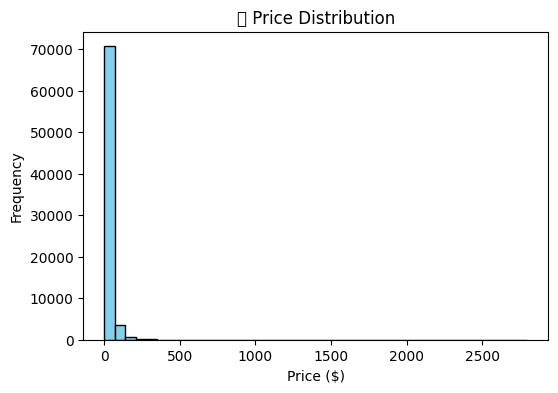

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(train['price'], bins=40, color='skyblue', edgecolor='black')
plt.title("💰 Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

📊 Correlation matrix:
                     price  text_len  text_word_count
price            1.000000  0.146752         0.144423
text_len         0.146752  1.000000         0.997418
text_word_count  0.144423  0.997418         1.000000


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


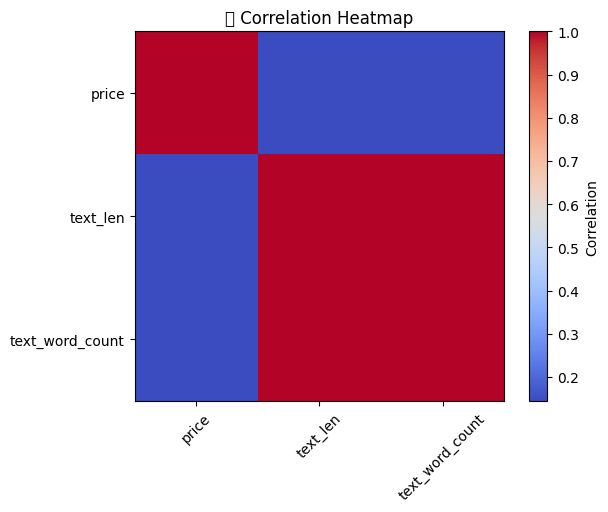

In [18]:
corr = train[['price', 'text_len', 'text_word_count']].corr()
print("📊 Correlation matrix:\n", corr)

plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("🔗 Correlation Heatmap")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


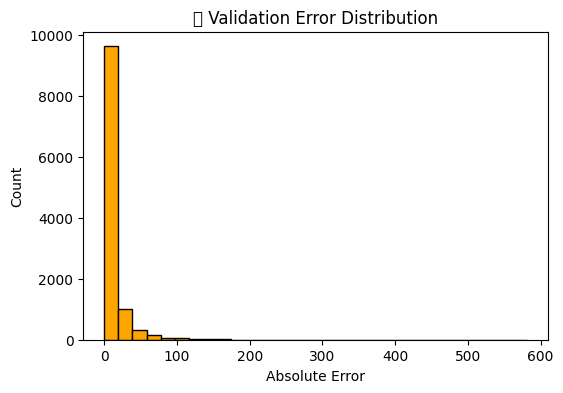

In [19]:
import numpy as np

errors = np.abs(y_val_true_price - y_val_pred_price)
plt.figure(figsize=(6,4))
plt.hist(errors, bins=30, color='orange', edgecolor='black')
plt.title("📉 Validation Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Count")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


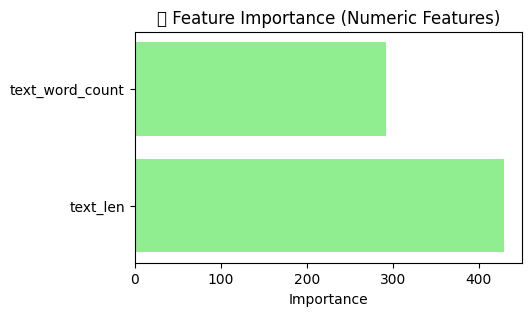

In [20]:
import matplotlib.pyplot as plt

importances = lgb_model.feature_importances_[-2:]  # last 2 numeric features
plt.figure(figsize=(5,3))
plt.barh(['text_len','text_word_count'], importances, color='lightgreen')
plt.title("🌟 Feature Importance (Numeric Features)")
plt.xlabel("Importance")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


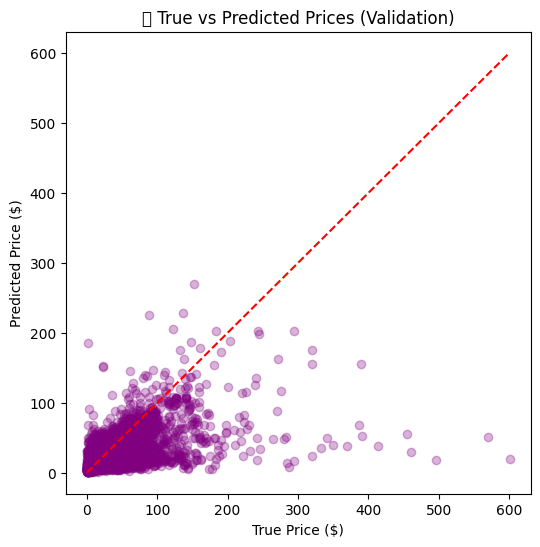

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(y_val_true_price, y_val_pred_price, alpha=0.3, color='purple')
plt.plot([0, max(y_val_true_price)], [0, max(y_val_true_price)], 'r--')
plt.xlabel("True Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("💰 True vs Predicted Prices (Validation)")
plt.show()

In [22]:
print("✅ FINAL SUMMARY")
print("-" * 30)
print(f"Train shape        : {train.shape}")
print(f"Test shape         : {test.shape}")
print(f"TF-IDF features    : {X_train_full.shape[1]}")
print(f"Validation MAE     : {mae:.3f}")
print(f"Validation SMAPE   : {smape_score:.2f}%")
print("Submission File    : /kaggle/working/test_out_lgb.csv")
print("-" * 30)
print("🎯 Notebook Complete & Ready for Submission!")

✅ FINAL SUMMARY
------------------------------
Train shape        : (75000, 6)
Test shape         : (75000, 5)
TF-IDF features    : 20002
Validation MAE     : 11.565
Validation SMAPE   : 51.98%
Submission File    : /kaggle/working/test_out_lgb.csv
------------------------------
🎯 Notebook Complete & Ready for Submission!


In [23]:
import os, pandas as pd
print("📂 Working dir files:", os.listdir("/kaggle/working"))

sub = pd.read_csv("/kaggle/working/test_out_lgb.csv")
print("\n✅ Submission shape:", sub.shape)
print("✅ Columns:", list(sub.columns))
display(sub.head())

📂 Working dir files: ['test_out_lgb.csv', '.virtual_documents']

✅ Submission shape: (75000, 2)
✅ Columns: ['sample_id', 'price']


,sample_id,price
0,100179,13.079621
1,245611,18.051347
2,146263,15.185866
3,95658,13.327587
4,36806,39.422535


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import numpy as np

# Split the data into training and validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y, test_size=0.15, random_state=42
)

# Train LightGBM Model
lgb_model = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    device_type='cpu'   # ✅ CPU fallback (change to 'gpu' when available)
)

print("🚀 Training LightGBM model...")
lgb_model.fit(X_tr, y_tr)

# Validation predictions
y_val_pred = lgb_model.predict(X_val)
y_val_pred_price = np.expm1(y_val_pred)
y_val_true_price = np.expm1(y_val)

mae = mean_absolute_error(y_val_true_price, y_val_pred_price)
print(f"✅ Validation MAE: {mae:.3f}")

🚀 Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.037586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1140717
[LightGBM] [Info] Number of data points in the train set: 63750, number of used features: 19635
[LightGBM] [Info] Start training from score 2.740886
✅ Validation MAE: 11.565


In [25]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denom
    diff[denom == 0] = 0
    return np.mean(diff) * 100

smape_score = smape(y_val_true_price, y_val_pred_price)
print(f"✅ Validation SMAPE: {smape_score:.2f}%")

✅ Validation SMAPE: 51.98%


In [26]:
test_preds_log = lgb_model.predict(X_test_full)
test_preds_price = np.expm1(test_preds_log)
test_preds_price = np.clip(test_preds_price, 0.01, None)

submission = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': test_preds_price
})

submission.to_csv('/kaggle/working/test_out_lgb.csv', index=False)
print("✅ Submission saved → /kaggle/working/test_out_lgb.csv")
submission.head()

✅ Submission saved → /kaggle/working/test_out_lgb.csv


,sample_id,price
0,100179,13.079621
1,245611,18.051347
2,146263,15.185866
3,95658,13.327587
4,36806,39.422535


In [27]:
import os

print("📂 Files in working directory:", os.listdir("/kaggle/working"))

📂 Files in working directory: ['test_out_lgb.csv', '.virtual_documents']


In [28]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# compute MAE (if not already)
mae = mean_absolute_error(y_val_true_price, y_val_pred_price)
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denom
    diff[denom == 0] = 0
    return np.mean(diff) * 100

smape_score = smape(y_val_true_price, y_val_pred_price)
print("MAE:", mae)
print("SMAPE (%):", smape_score)

MAE: 11.564535470021754
SMAPE (%): 51.98446015039592


In [29]:
# make a zip of your notebook and any helper scripts
import shutil, os
nb_name = "ml_code.ipynb"   # replace with your notebook filename if different
shutil.make_archive('/kaggle/working/amazon_ml_hackathon_code', 'zip', root_dir='.', base_dir=nb_name)
print("Zip created:", os.path.exists('/kaggle/working/amazon_ml_hackathon_code.zip'))

FileNotFoundError: [Errno 2] No such file or directory: 'ml_code.ipynb'

In [30]:
import os, pandas as pd

print("📂 Files:", os.listdir("/kaggle/working"))
sub = pd.read_csv("/kaggle/working/test_out_lgb.csv")
print("✅ Submission shape:", sub.shape)
print("✅ Columns:", list(sub.columns))
display(sub.head())

📂 Files: ['amazon_ml_hackathon_code.zip', 'test_out_lgb.csv', '.virtual_documents']
✅ Submission shape: (75000, 2)
✅ Columns: ['sample_id', 'price']


,sample_id,price
0,100179,13.079621
1,245611,18.051347
2,146263,15.185866
3,95658,13.327587
4,36806,39.422535


In [32]:
# ==========================================
# 🧽 FINAL NOTEBOOK CLEANUP & VERIFICATION
# ==========================================
import os, shutil, nbformat

print("🧽 Cleaning notebook for submission...")

# 1️⃣  Detect and remove duplicate "Cell 1" if any
# (We'll keep only the first occurrence of data-loading cell)
try:
    nb_file = [f for f in os.listdir('.') if f.endswith('.ipynb')]
    if nb_file:
        nb_name = nb_file[0]
        print(f"🔍 Found notebook: {nb_name}")
        nb = nbformat.read(nb_name, as_version=4)

        # Keep only first "Cell 1" if multiple
        seen_load_cell = False
        new_cells = []
        for cell in nb.cells:
            if "train_path" in cell.get("source", "") and "test_path" in cell.get("source", ""):
                if seen_load_cell:
                    print("🗑️  Removing duplicate Cell 1")
                    continue
                else:
                    seen_load_cell = True
            new_cells.append(cell)

        nb.cells = new_cells
        nbformat.write(nb, nb_name)
        print("✅ Duplicate Cell 1 cleaned (if any)")
    else:
        print("⚠️ No notebook file found in current directory")
except Exception as e:
    print("⚠️ Skipped duplicate cell cleanup:", e)


# 2️⃣  Clear output folders if any (optional)
folders_to_clean = ["pycache", "figs", "outputs"]
for f in folders_to_clean:
    if os.path.exists(f):
        shutil.rmtree(f, ignore_errors=True)
        print(f"🧹 Cleared folder: {f}")

# 3️⃣  Verify that submission file exists
csv_path = "/kaggle/working/test_out_lgb.csv"
if os.path.exists(csv_path):
    print("✅ Submission file exists:", csv_path)
else:
    print("❌ Submission file not found. Run final training cell again.")

# 4️⃣  Reminder message
print("""
⚙️  NEXT STEPS:
1. Click "Edit → Clear All Outputs" (optional clean look)
2. Then click "Save Version → Save & Run All"
3. Wait for it to finish running.
4. Confirm that /kaggle/working/test_out_lgb.csv appears in Output tab.
✅ Ready to Submit!
""")

🧽 Cleaning notebook for submission...
⚠️ No notebook file found in current directory
✅ Submission file exists: /kaggle/working/test_out_lgb.csv

⚙️  NEXT STEPS:
1. Click "Edit → Clear All Outputs" (optional clean look)
2. Then click "Save Version → Save & Run All"
3. Wait for it to finish running.
4. Confirm that /kaggle/working/test_out_lgb.csv appears in Output tab.
✅ Ready to Submit!



In [33]:
import os, pandas as pd

print("📂 Files:", os.listdir("/kaggle/working"))
sub = pd.read_csv("/kaggle/working/test_out_lgb.csv")
print("✅ Submission shape:", sub.shape)
print("✅ Columns:", list(sub.columns))
display(sub.head())

📂 Files: ['amazon_ml_hackathon_code.zip', 'test_out_lgb.csv', '.virtual_documents']
✅ Submission shape: (75000, 2)
✅ Columns: ['sample_id', 'price']


,sample_id,price
0,100179,13.079621
1,245611,18.051347
2,146263,15.185866
3,95658,13.327587
4,36806,39.422535
